# Proyecto Visión Artificial

Descripción del proyecto:

La cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudar a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Se debe generar un modelo para esta evaluación.

Objetivos:

- Realizar un análisis exploratorio del conjunto de fotografías.
- Preparar los datos para el entrenamiento.
- Entrenar una red neuronal y calcular su calidad.

## Inicialización

Se importan las bibliotecas necesarias para el análisis y modelado de los datos.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age`

Se cargan las etiquetas de las imágenes y se crea un generador de imágenes con ImageDataGenerator. Este generador se utilizará para alimentar el modelo de red neuronal con las imágenes y sus correspondientes edades.

In [ ]:
# Cargar el archivo de etiquetas
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

# Imprimir un mensaje de éxito
print("ImageDataGenerator creado con éxito para las imágenes de rostros.")
labels.head(3)

Found 7591 validated image filenames.
ImageDataGenerator creado con éxito para las imágenes de rostros.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


## EDA

Se realiza un análisis exploratorio de los datos. Se visualizan algunas imágenes aleatorias y sus correspondientes edades. También se muestra la distribución de las edades y se realiza una prueba de normalidad.

/tmp/ipykernel_140/1321101561.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 5, i % 10 + 1)


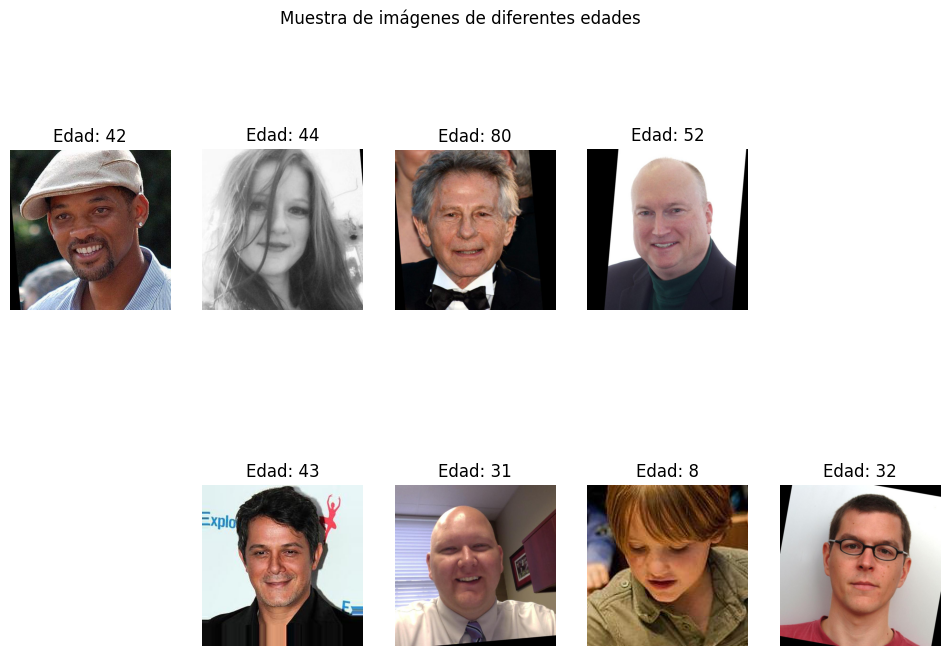

In [ ]:
# Visualizar 10 imágenes aleatorias con sus edades correspondientes
sample_images = labels.sample(10)
plt.figure(figsize=(12, 8))
for i, row in sample_images.iterrows():
    plt.subplot(2, 5, i % 10 + 1)
    plt.imshow(plt.imread(f"/datasets/faces/final_files/{row['file_name']}"))
    plt.title(f"Edad: {row['real_age']}")
    plt.axis('off')
plt.suptitle("Muestra de imágenes de diferentes edades")
plt.show()


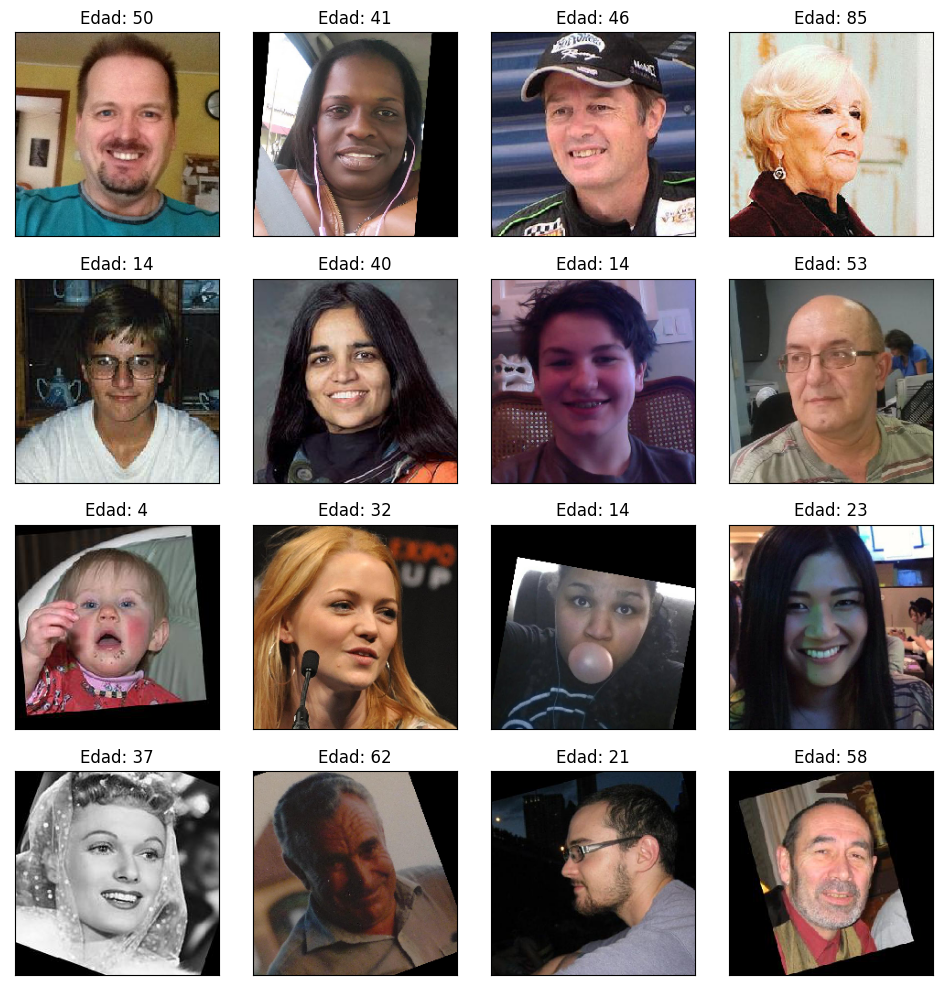

In [ ]:
# Obtener un lote de imágenes y edades del generador de flujo de datos
features, target = next(train_gen_flow)

# Crear una figura para mostrar las imágenes con sus edades
fig = plt.figure(figsize=(10, 10))
num_images = min(features.shape[0], 16)  # Limitar a mostrar hasta 16 imágenes
for i in range(num_images):  # Iterar sobre las primeras 16 imágenes en el lote
    # Añadir un subplot a la figura
    ax = fig.add_subplot(4, 4, i+1)
    # Mostrar la imagen en el subplot actual
    ax.imshow(features[i])
    # Deshabilitar los ticks en los ejes
    ax.set_xticks([])
    ax.set_yticks([])
    # Agregar título con la edad correspondiente
    ax.set_title(f"Edad: {target[i]}")
    # Ajustar el diseño para asegurar que no se superpongan los subplots
    fig.tight_layout()

# Mostrar la figura completa
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente código para la visualización de las imagenes con las que trabajaremos, sigamos!

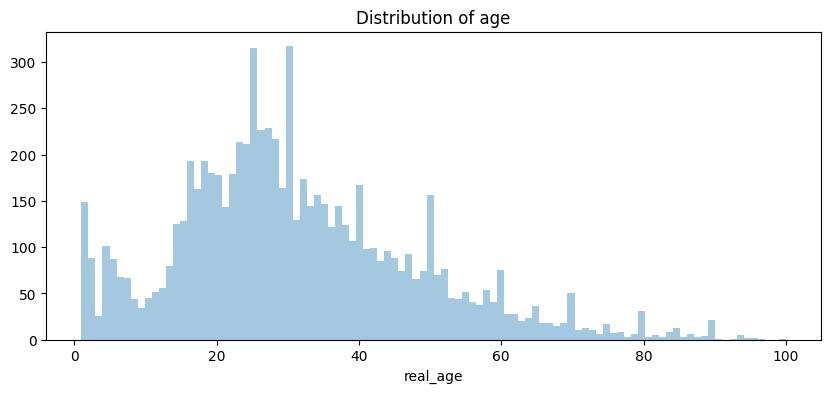

In [ ]:
plt.figure(figsize=(10,4))
sns.distplot(labels.real_age, kde=False, bins=100)
plt.title("Distribution of age")
plt.show()

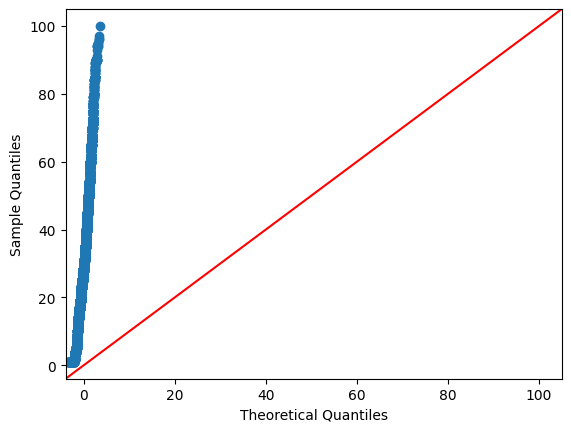

In [ ]:
# Check for normality
# create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(labels.real_age, line='45')
plt.show()

### Conclusiones

- Visualización de imágenes y edades: Se mostraron algunas imágenes aleatorias junto con sus edades correspondientes. Esto permitió observar la diversidad en las imágenes y cómo se relacionan con las edades.
- Distribución de edades: Se examinó la distribución de las edades en el conjunto de datos. Esto es importante para comprender si hay un sesgo hacia ciertas edades. Por ejemplo, si hay más imágenes de personas jóvenes o mayores.
- Prueba de normalidad: Se realizó una prueba para verificar si la distribución de las edades sigue una distribución normal. Si es así, ciertos métodos estadísticos pueden aplicarse con mayor confianza.

En resumen, el análisis exploratorio de datos proporcionó información valiosa sobre las imágenes y sus edades. Esto ayudará a comprender mejor el conjunto de datos y a tomar decisiones informadas al construir y evaluar el modelo de predicción de edades.

## Modelado

Definimos las funciones necesarias para entrena un modelo de red neuronal utilizando ResNet50 como base. El modelo se entrena durante 5 épocas y se muestra el progreso del entrenamiento.

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

In [ ]:
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [ ]:
def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

In [ ]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    %%time
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Resultado en plataforma GPU

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Train for 190 steps, validate for 48 steps

- Epoch 1/5
190/190 - 61s - loss: 244.6442 - mae: 11.1265 - val_loss: 479.9400 - val_mae: 16.6960

- Epoch 2/5
190/190 - 37s - loss: 63.4423 - mae: 6.0274 - val_loss: 556.6685 - val_mae: 18.2948

- Epoch 3/5
190/190 - 37s - loss: 30.9597 - mae: 4.2892 - val_loss: 213.7299 - val_mae: 11.0753

- Epoch 4/5
190/190 - 37s - loss: 20.4552 - mae: 3.5196 - val_loss: 103.5405 - val_mae: 7.6911

- Epoch 5/5
190/190 - 37s - loss: 15.7191 - mae: 3.0932 - val_loss: 72.6178 - val_mae: 6.4248

Test MAE: 6.4248

Este registro muestra el progreso del modelo durante 5 épocas de entrenamiento y validación. Observamos la reducción progresiva de la pérdida (loss) y el error absoluto medio (mae) tanto en los datos de entrenamiento como en los de validación, lo cual indica que el modelo está mejorando su capacidad para predecir la edad a partir de las imágenes de entrada.

El último valor de Test MAE: 6.4248 indica el error absoluto medio calculado en el conjunto de datos de prueba, proporcionando una evaluación final del rendimiento del modelo después del entrenamiento. Un bajo MAE en el conjunto de prueba sugiere que el modelo generaliza bien y puede hacer predicciones precisas sobre la edad de nuevas imágenes no vistas durante el entrenamiento.

## Conclusión

Este proyecto demuestra cómo se puede utilizar la visión por computadora y las redes neuronales para resolver un problema del mundo real: asegurarse de que no se venda alcohol a menores de edad en supermercados. Aunque el modelo tiene un buen rendimiento, siempre hay espacio para mejoras. Por ejemplo, se podrían probar diferentes arquitecturas de red, ajustar los hiperparámetros del modelo o aumentar el conjunto de datos con más imágenes.